# How to use histopathology images in CC3D

In order to use histopathology images in CC3D we need to have the cell segmentation first. The cell borders are very hard to see in H&E stained slides, therefore we first segment the nuclei and then approximate the cell border. Lastly, we load in the confirguration in CC3D.

This notebook is divided in three parts:
1. Segment the cell nuclei with HoverNet (Code based on the Hovernet usage example notebook)
2. Estimate the cell borders with voronoi tesselations (scipy)
3. Load in the data in CC3D

# 1. Segment the cell nuclei with HoverNet (Code based on the Hovernet usage example notebook)

HoverNet can segment the nuclei in H&E whole-slide images (WSIs) and tiles. I primarly use the tiles, since my laptop cannot handle WSI.

For tile processing, the input must be in a standard image format, such as `.jpg` or `.png`. 

The output of HoverNet is:

- A `.json` file that contains:
        - bounding box coordinates for each nucleus
        - centroid coordinates for each nucleus
        - contour coordinates for each nucleus 
        - nucleus type predictions
        - per class probabilities for each nucleus (optional)
- A `.mat` and overlay file. The `.mat` file contains:
        - raw output of network (optional)
        - instance map containing values from 0 to N, where N is the number of nuclei
        - list of length N containing predictions for each nucleus

In [187]:
# Define the path to the .tif image
img_path = r'C:\Users\yihez\Desktop\Yogi-de-Pogi\University\Graduation-BME\code\BME-thesis\dataset\Camelyon\img\CAMELYON17\patient_021_node_3.tif'
output_path = r'C:\Users\yihez\Desktop\Yogi-de-Pogi\University\Graduation-BME\code\BME-thesis\exp_output\Example\output'
save_dir_patch = Path(r'C:\Users\yihez\Desktop\Yogi-de-Pogi\University\Graduation-BME\code\BME-thesis\exp_output\Example\patch')
segmentation_path = Path(r'C:\Users\yihez\Desktop\Yogi-de-Pogi\University\Graduation-BME\code\BME-thesis\exp_output\Example\segmentation')

HoverNet can handle WSI, but my laptop cannot. Therefore patch the data:

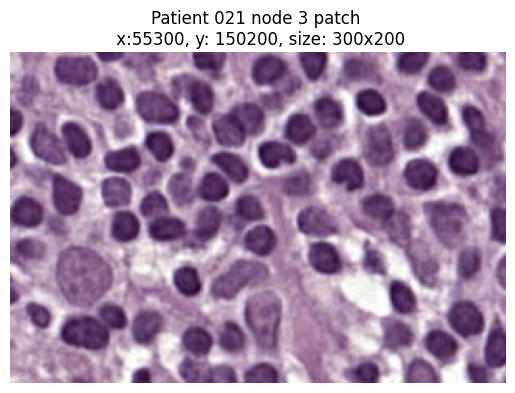

In [22]:
import multiresolutionimageinterface as mir
from matplotlib import pyplot as plt
# Give the starting cropping coordinates (LU) and the size
coord_x = 55300
coord_y = 150200
size_x = 300
size_y = 200

reader = mir.MultiResolutionImageReader()
mr_image = reader.open(img_path)
level = 0
ds = mr_image.getLevelDownsample(level)
image_patch = mr_image.getUCharPatch(int(coord_x * ds), int(coord_y * ds), size_x, size_y, level)

plt.imshow(image_patch)
plt.title(f'Patient 021 node 3 patch \n x:{coord_x}, y: {coord_y}, size: {size_x}x{size_y}')
plt.axis('off')
plt.show()

In [82]:
# Save the patch

from PIL import Image
from pathlib import Path
def img_save(img, save_dir, name):
    img_2_save = Image.fromarray(img, 'RGB')
    img_2_save.save(save_dir / name)
    return

title = "patient_021_node_3_patch_55300_150200_300_200"
name = title + ".png"
img_save(image_patch, save_dir_patch, name)

<b>Run the HoverNet with the following windows shell prompt</b>

`
!python ..\hover_net\run_infer.py 
--nr_types=0 
--batch_size=32
--model_mode=fast 
--model_path=../dataset/weights/hovernet_fast_monusac_type_tf2pytorch.tar 
--nr_inference_workers=8 
--nr_post_proc_workers=16 
tile 
--input_dir= <save_dir_patch> 
--output_dir= <output_path>
`

There must be at least 2 patches in your folder, otherwise it doesn't work.

In [77]:
!python C:\Users\yihez\Desktop\Yogi-de-Pogi\University\Graduation-BME\code\BME-thesis\hover_net\run_infer.py --nr_types=0 --batch_size=32 --model_mode=fast --model_path=../dataset/weights/hovernet_fast_monusac_type_tf2pytorch.tar --nr_inference_workers=8 --nr_post_proc_workers=16 tile --input_dir=C:\Users\yihez\Desktop\Yogi-de-Pogi\University\Graduation-BME\code\BME-thesis\exp_output\Example\patch --output_dir=C:\Users\yihez\Desktop\Yogi-de-Pogi\University\Graduation-BME\code\BME-thesis\exp_output\Example\output

|2024-02-16|07:36:24.682| [INFO] .... Detect #GPUS: 1

Process Patches: 100%|############################| 1/1 [00:21<00:00, 21.23s/it]
Process Patches: 2it [00:21,  8.85s/it]                                         
Process Patches: 3it [00:21,  4.89s/it]
Process Patches: 4it [00:21,  3.03s/it]
Process Patches: 5it [00:21,  2.00s/it]
Process Patches: 6it [00:22,  1.39s/it]
Process Patches: 7it [00:22,  1.01it/s]
Process Patches: 8it [00:22,  1.36it/s]
Process Patches: 8it [00:22,  2.85s/it]
|2024-02-16|07:36:52.530| [INFO] ........................ Done Assembling patient_021_node_3_patch_55300_150200_300_200_2nd
|2024-02-16|07:36:52.546| [INFO] ........................ Done Assembling patient_021_node_3_patch_55300_150200_300_200


In [120]:
# load the libraries

import sys
sys.path.append('../')

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import scipy.io as sio
import cv2
import json

OPENSLIDE_PATH = r'C:\Users\yihez\Desktop\Yogi-de-Pogi\University\Graduation-BME\code\openslide-win64-20221217\openslide-win64-20221217\bin'
if hasattr(os, 'add_dll_directory'):
    # Python >= 3.8 on Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

from hover_net.misc.wsi_handler import get_file_handler
from hover_net.misc.viz_utils import visualize_instances_dict

In [121]:
# define the tile and output paths
tile_path = Path(save_dir_patch, name)
tile_json_path = Path(output_path, "json", title+".json")
tile_mat_path = Path(output_path, "mat", title+".mat")
tile_overlay_path = Path(output_path,"overlay", name)

## Tile Processing Output

First let's view the 2D output from tile processing mode, that is stored in a `.mat` file.

In [139]:
image = plt.imread(tile_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# get the corresponding `.mat` file 
result_mat = sio.loadmat(tile_mat_path)

# get the overlay
overlay = plt.imread(tile_overlay_path)
overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

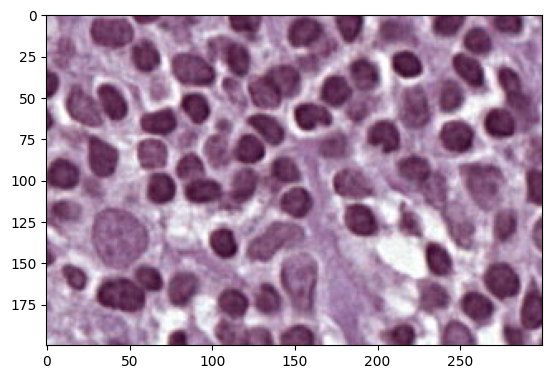

In [140]:
plt.imshow(image)

Now, let's view the contents of the `.json` file.

In [154]:
# load the json file and add the contents to corresponding lists

bbox_list = []
centroid_list = []
contour_list = [] 
type_list = []

with open(tile_json_path) as json_file:
    data = json.load(json_file)
    mag_info = data['mag']
    nuc_info = data['nuc']
    for inst in nuc_info:
        inst_info = nuc_info[inst]
        inst_centroid = inst_info['centroid']
        centroid_list.append(inst_centroid)
        inst_contour = inst_info['contour']
        contour_list.append(inst_contour)
        inst_bbox = inst_info['bbox']
        bbox_list.append(inst_bbox)
        inst_type = inst_info['type']
        type_list.append(inst_type)

In [155]:
# get the number of items in each list

print('Number of centroids', len(centroid_list))
print('Number of contours', len(contour_list))
print('Number of bounding boxes', len(bbox_list))

# each item is a list of coordinates - let's take a look!
print('-'*60)
print(centroid_list[0])
print('-'*60)
print(contour_list[0])
print('-'*60)
print(bbox_list[0])

Number of centroids 71
Number of contours 71
Number of bounding boxes 71
------------------------------------------------------------
[60.037974683544306, 2.088607594936709]
------------------------------------------------------------
[[52, 0], [53, 1], [53, 2], [56, 5], [62, 5], [63, 4], [64, 4], [65, 3], [67, 3], [68, 2], [68, 1], [67, 0]]
------------------------------------------------------------
[[0, 52], [6, 69]]


In [207]:
# get a single contour, bounding box and centroid and visualise
rand_nucleus = np.random.randint(0, len(centroid_list))
rand_centroid = centroid_list[rand_nucleus]
rand_bbox = bbox_list[rand_nucleus]
rand_contour = contour_list[rand_nucleus]

# draw the overlays
overlay = image.copy()
overlay = cv2.drawContours(overlay.astype('float32'), [np.array(rand_contour)], -1, (255,255,0), 1)
overlay = cv2.circle(overlay.astype('float32'),(np.round(rand_centroid[0]).astype('int'), np.round(rand_centroid[1]).astype('int')), 3, (0,255,0), -1)
overlay = cv2.rectangle(overlay.astype('float32'), (rand_bbox[0][1], rand_bbox[0][0]), (rand_bbox[1][1], rand_bbox[1][0]), (255,0,0), 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


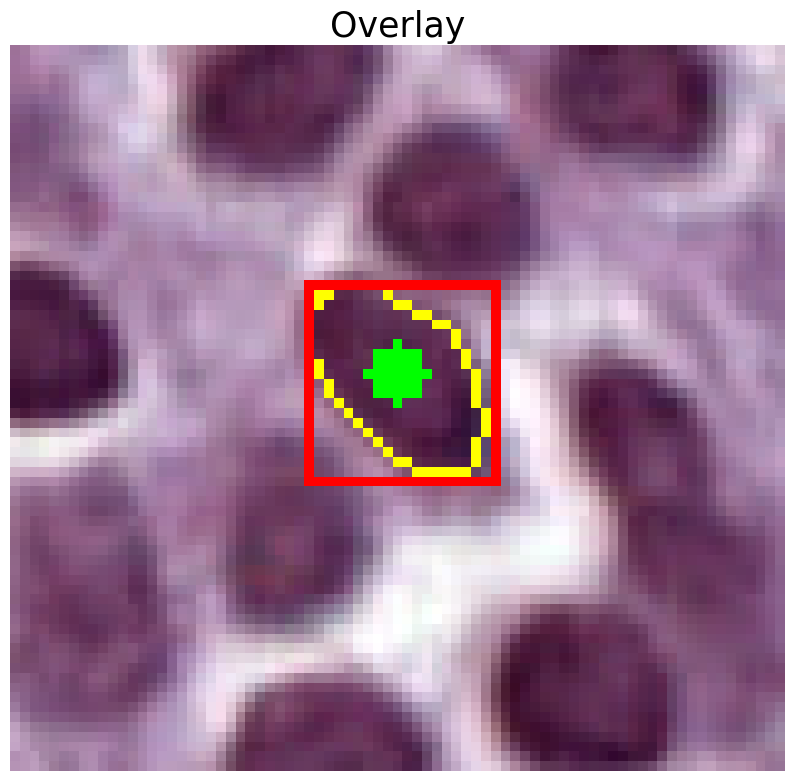

In [208]:
# plot the cropped overlay
pad = 30
crop1 = rand_bbox[0][0]-pad
if crop1 < 0: 
    crop1 = 0
crop2 = rand_bbox[1][0]+pad
if crop2 > overlay.shape[0]: 
    crop2 = overlay.shape[0]
crop3 = rand_bbox[0][1]-pad
if crop3 < 0: 
    crop3 = 0
crop4 = rand_bbox[1][1]+pad
if crop4 > overlay.shape[1]: 
    crop4 = overlay.shape[1]
crop_overlay = overlay[crop1:crop2,crop3:crop4,:]
plt.figure(figsize=(10,10))

plt.imshow(crop_overlay, vmin=0, vmax=1)
plt.axis('off')
plt.title('Overlay', fontsize=25)
plt.show()

# 2. Estimate the cell borders with voronoi tesselations (scipy)

We approximate the cell borders with Voronoi tesselation, since the cell borders are very hard to detect in the H&E images. I have onmitted the cell nuclei from the final segmentations, since the Voronoi edges and the nuclei collide with each other sometimes. #TODO will fix this this weekend

In [169]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [220]:
vor = Voronoi(centroid_list)

In [221]:
# Make contours on the image
overlay = image.copy()
for contour in contour_list:
    overlay = cv2.drawContours(overlay.astype('float32'), [np.array(contour)], -1, (255,255,0), 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


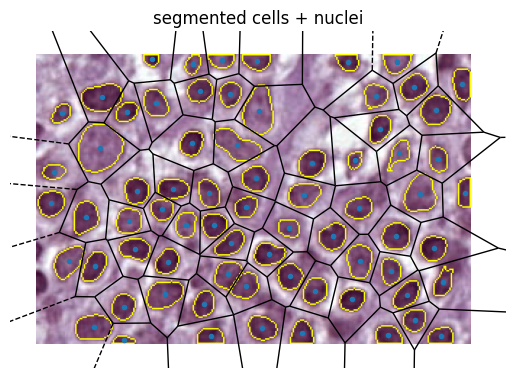

In [234]:
fig = voronoi_plot_2d(vor, show_vertices=False)
plt.imshow(overlay)
plt.axis('off')
plt.title("segmented cells + nuclei")
plt.show()

## Voronoi attributes

Voronoi object has the following attributes:

points
ndarray of double, shape (npoints, ndim)
Coordinates of input points.

vertices
ndarray of double, shape (nvertices, ndim)
Coordinates of the Voronoi vertices.

ridge_points
ndarray of ints, shape (nridges, 2)
Indices of the points between which each Voronoi ridge lies.

ridge_vertices
list of list of ints, shape (nridges, *)
Indices of the Voronoi vertices forming each Voronoi ridge.

regions
list of list of ints, shape (nregions, *)
Indices of the Voronoi vertices forming each Voronoi region. -1 indicates vertex outside the Voronoi diagram. When qhull option “Qz” was specified, an empty sublist represents the Voronoi region for a point at infinity that was added internally.

point_region
array of ints, shape (npoints)
Index of the Voronoi region for each input point. If qhull option “Qc” was not specified, the list will contain -1 for points that are not associated with a Voronoi region. If qhull option “Qz” was specified, there will be one less element than the number of regions because an extra point at infinity is added internally to facilitate computation.

furthest_site
True if this was a furthest site triangulation and False if not.

<b>This ugly code down here, removes the unfinished cells at the edges and colours the cells in a solid color. This is needed for the cell position initialization.</b>

In [235]:
def get_line_coordinates(x1, y1, x2, y2):
    """
    returns the pixel coordinates that draws a line between two points in a 2D space
    """
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    steep = dy > dx

    if steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
        dx, dy = dy, dx

    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1

    error = dx / 2.0
    y_step = 1 if y1 < y2 else -1
    y = y1

    line_coordinates = []
    for x in range(x1, x2 + 1):
        line_coordinates.append((y, x) if steep else (x, y))
        error -= dy
        if error < 0:
            y += y_step
            error += dx
    return line_coordinates


In [236]:
def find_cycles(graph, start, node, visited, path, cycles):
    visited.add(node)
    path.append(node)

    for neighbor in graph[node]:
        if neighbor == start:
            cycles.append(path[:] + [start])  # Add the cycle to the list
        elif neighbor not in visited:
            find_cycles(graph, start, neighbor, visited, path, cycles)

    visited.remove(node)
    path.pop()

def find_minimal_cycles(vertices, edges):
    graph = {}
    for vertex in vertices:
        graph[vertex] = []

    for edge in edges:
        u, v = edge
        graph[u].append(v)

    cycles = []
    for vertex in graph:
        visited = set()
        path = []
        find_cycles(graph, vertex, vertex, visited, path, cycles)

    minimal_cycles = []
    for cycle in cycles:
        is_minimal = True
        for other_cycle in cycles:
            if cycle != other_cycle and set(cycle).issubset(other_cycle):
                is_minimal = False
                break
        if is_minimal:
            minimal_cycles.append(cycle)

    return minimal_cycles

# Example usage
vertices = [1, 2, 3, 4, 5]  # Example vertices
edges = [(1, 2), (2, 3), (3, 4), (4, 2), (4, 5)]  # Example edges

minimal_cycles = find_minimal_cycles(vertices, edges)
print(minimal_cycles)  # Output: [[1, 2, 3, 4], [4, 2, 3]]

[]


In [291]:
import cv2
from PIL import ImageDraw
def make_cell_img(img_size, voronoi, cell_coord, color=(255,0,0,255)):
    vertice_int = list(map(lambda vertice: [int(vertice[0]), int(vertice[1])], map(np.round, vor.vertices))) # pixelize all vertice coordinates
    
    # Is_in_img contains all the vertices that are contained in the images border
    is_in_img = np.ones(len(vertice_int))
    
    max_y, max_x, _ = np.shape(image)
    print(f"max x is {max_x} and max y is {max_y}")
    for i, (x, y) in enumerate(vertice_int):
        if x<0 or x>=max_x or y<0 or y>=max_y:
            is_in_img[i] = 0
    
    # initialize the final image
    img = np.ones(img_size)*255    
    full_regions = []
    
    # GET THE VERTICES THAT ARE INSIDE THE IMAGE
    unique_vertices = []
    for i, bool_is_in_img in enumerate(is_in_img):
        if bool_is_in_img == 1:
            unique_vertices.append(i)
            
    vertice_deg = {}
    for ridge_vertice in vor.ridge_vertices:
        ver1, ver2 = ridge_vertice
        if ver1 in unique_vertices and ver2 in unique_vertices:
            vertice_deg.setdefault(ver1, []).append(ver2)
            vertice_deg.setdefault(ver2, []).append(ver1)
    
    has_leaves = True
    while has_leaves:
        has_leaves = False
        for is_leaf_vertice in vertice_deg.keys():
            if len(vertice_deg[is_leaf_vertice]) == 1 and not vertice_deg[is_leaf_vertice][0] == -1:
                vertice_deg[is_leaf_vertice] = [-1]
                for vertice in vertice_deg.keys():
                    if is_leaf_vertice in vertice_deg[vertice]:
                        vertice_deg[vertice].remove(is_leaf_vertice)
                    has_leaves = True
            
    for ridge_vertice in vor.ridge_vertices:
        ver1, ver2 = ridge_vertice
        if ver1 in unique_vertices and ver2 in unique_vertices and len(vertice_deg[ver1]) >= 2 and len(vertice_deg[ver2]) >= 2 :      
            x1, y1 = vertice_int[ver1]
            x2, y2 = vertice_int[ver2]
            line_coords = get_line_coordinates(x1, y1, x2, y2)
            for line_x, line_y in line_coords:
                img[line_y][line_x] = (0,0,0)

    return img

max x is 300 and max y is 200


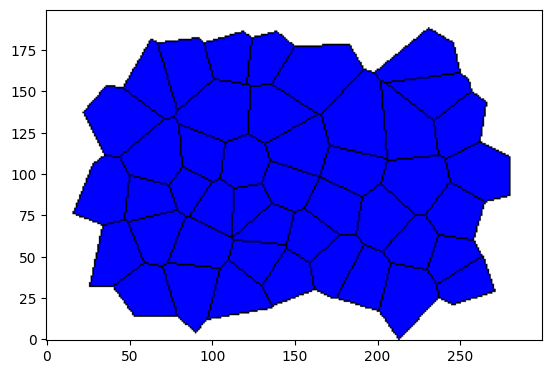

True

In [313]:
img = make_cell_img(np.shape(image), vor, [])
pil_img = Image.fromarray(np.uint8(img))
ImageDraw.floodfill(pil_img, xy=(0,0), value=(255,0,0,255))

img = np.asarray(pil_img)

# Create a boolean mask to find the pattern [1, 0, 1] in the last dimension
mask_cytoplasm = np.all(img == [255, 0, 0], axis=2)
mask_cells = np.all(img == [255, 255, 255], axis=2)
img_col = img.copy()
# Replace the pattern with [3, 3, 3]
img_col[mask_cytoplasm] = [255, 255, 255]
img_col[mask_cells] = [0, 0, 255]


fig, ax = plt.subplots()


# Plot the first image with alpha = 0.5 (50% transparency)
ax.imshow(image, alpha=1)
# Plot the second image with alpha = 0.7 (70% transparency)
ax.imshow(img_col, alpha=1, origin='lower')

plt.show()


# Save the image
cv2.imwrite('example_segmentation.png', img_col)

In [309]:
## STILL NEED TO FIX ##

# seg = img.copy()
# for contour in contour_list:
#     seg = cv2.drawContours(seg.astype('float32'), [np.array(contour)], -1, (255,255,0), 1)

# # Create a new figure
# fig, ax = plt.subplots()

# # Plot the first image with alpha = 0.5 (50% transparency)
# ax.imshow(image, alpha=1)

# # Plot the second image with alpha = 0.7 (70% transparency)
# ax.imshow(img, alpha=1, origin='lower')


# # Plot the second image with alpha = 0.7 (70% transparency)
# ax.imshow(seg, alpha=1, origin='lower')

# plt.show()

# # Save the image
# cv2.imwrite('example_segmentation.png', img)

# 3. Load in the data in CC3D
I adjusted the CC3D code made by J Sluka Sept. 2020 to load in .png images and convert them to .piff files, see `img2piff_example`. These files can then be used as initial start position for compucell3D. The notes in the code should be clear, but I'll revise it and comment it better.

You can then use this in the .CC3D file to initialize the model:
`<PIFFile>C:\CompuCell3D\(<path_to_piff>, 'All Files (*)')</PIFFile>`